# Assignment 5(ii)
# Nidhi
# MDS202222

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Authenticate and mount Google Drive


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load training and test data


In [5]:
train_df = pd.read_csv('/content/drive/My Drive/Assignment 5_2/train.csv', encoding="latin1").dropna()
test_df = pd.read_csv('/content/drive/My Drive/Assignment 5_2/test.csv', encoding="latin1").dropna()


# Check if GPU is available


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# Map sentiments to labels


In [7]:
sentiment_to_label = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['label'] = train_df['sentiment'].map(sentiment_to_label)
test_df['label'] = test_df['sentiment'].map(sentiment_to_label)


In [8]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text, label = row['text'], row['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
train_dataset = TextDataset(train_df, tokenizer)
test_dataset = TextDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
for epoch in range(5):
    model.train()
    total_loss, total_batches = 0.0, 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_batches += 1

        if batch_idx % 1000 == 999:
            print(f"Epoch {epoch+1}/2, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    print(f"\nEpoch {epoch+1}/2, Average Training Loss: {total_loss / total_batches}\n")

Epoch 1/2, Batch 1000/3435, Loss: 0.6952493786811829
Epoch 1/2, Batch 2000/3435, Loss: 0.5286887288093567
Epoch 1/2, Batch 3000/3435, Loss: 0.6776953935623169

Epoch 1/2, Average Training Loss: 0.5691003273570642

Epoch 2/2, Batch 1000/3435, Loss: 0.4824639558792114
Epoch 2/2, Batch 2000/3435, Loss: 0.7633288502693176
Epoch 2/2, Batch 3000/3435, Loss: 0.26101309061050415

Epoch 2/2, Average Training Loss: 0.40176849288586663

Epoch 3/2, Batch 1000/3435, Loss: 0.4389289915561676
Epoch 3/2, Batch 2000/3435, Loss: 0.16751715540885925
Epoch 3/2, Batch 3000/3435, Loss: 0.14346210658550262

Epoch 3/2, Average Training Loss: 0.25630316545202614

Epoch 4/2, Batch 1000/3435, Loss: 0.009396164678037167
Epoch 4/2, Batch 2000/3435, Loss: 0.01238301582634449
Epoch 4/2, Batch 3000/3435, Loss: 0.03909064456820488

Epoch 4/2, Average Training Loss: 0.15072083964752742

Epoch 5/2, Batch 1000/3435, Loss: 0.02421606332063675
Epoch 5/2, Batch 2000/3435, Loss: 0.17116263508796692
Epoch 5/2, Batch 3000/3435

In [13]:
# Switch model to evaluation mode
model.eval()

# Initialize lists for true labels and predictions
actual_labels = []
predicted_labels = []

# Disable gradient calculations
with torch.no_grad():
    # Iterate over batches in the test loader
    for data_batch in test_loader:
        # Move batch tensors to the same device as the model
        input_ids = data_batch["input_ids"].to(device)
        attention_mask = data_batch["attention_mask"].to(device)
        labels = data_batch["labels"]

        # Extend the actual labels list
        actual_labels.extend(labels.tolist())

        # Perform a forward pass through the model
        model_output = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the predicted labels
        _, preds = torch.max(model_output.logits, 1)

        # Extend the predicted labels list
        predicted_labels.extend(preds.tolist())

In [16]:
# Print the classification report
print(classification_report(actual_labels, predicted_labels, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.73      0.82      0.77      1001
     neutral       0.76      0.70      0.73      1430
    positive       0.84      0.82      0.83      1103

    accuracy                           0.77      3534
   macro avg       0.77      0.78      0.78      3534
weighted avg       0.77      0.77      0.77      3534



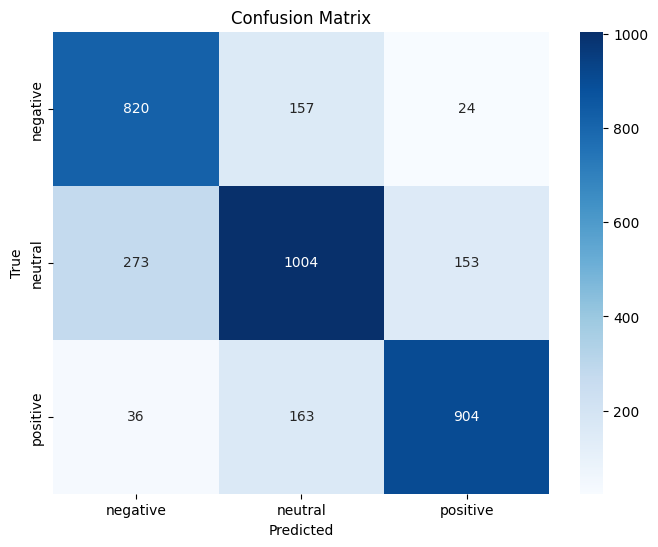

In [17]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()